In [237]:
import pickle 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

In [238]:
with open('simulation_results_jorgi/hor=3, rate=2, reps=weeks=52/metrics.pickle', 'rb') as file:
    metrics1 = pickle.load(file)
    
with open('simulation_results_jorgi/hor=3, rate=2, reps=weeks=52/selection.pickle', 'rb') as file:
    selection1 = pickle.load(file)
    
with open('simulation_results/metrics.pickle', 'rb') as file:
    metrics2 = pickle.load(file)
    
for dicc in metrics2:
    dicc['rep'] += 52
    
with open('simulation_results/selection.pickle', 'rb') as file:
    selection2 = pickle.load(file)
    
with open('simulation_results/abogados.pickle', 'rb') as file:
    lawyers = pickle.load(file)
    
with open('simulation_results/decodificacion.pickle', 'rb') as file:
    specialty_decod = pickle.load(file)
    
metrics = metrics1 + metrics2
selection = selection1 + selection2
    
specialty_decod = {key: value.replace("n1", "") for key, value in specialty_decod.items()}

# Analisis de los tiempos de los abogados #

In [239]:
areas = set()
for area_l in lawyers["areas"]:
    for area in area_l: areas.add(area)

area_dict = {area: [] for area in areas}
for i, area_l in enumerate(lawyers["areas"]):
    for area in area_dict:
        if area in area_l:
            area_dict[area].append(i)
            
A = len(area_dict)
area_dict

{3: [14, 15, 16, 17],
 292: [21],
 168: [19],
 74: [3, 4, 5, 6, 9, 12, 13],
 52: [3, 4, 14, 15, 16, 17],
 189: [10],
 119: [0, 1, 2],
 153: [18],
 221: [7, 8, 11],
 94: [3, 4, 5, 6, 9, 13, 20, 22],
 63: [3, 4, 5, 6, 9, 12, 13]}

In [240]:
areas_list = sorted(list(areas))
areas_idx = {area: i for i, area in enumerate(areas)}
areas_idx

{3: 0,
 292: 1,
 168: 2,
 74: 3,
 52: 4,
 189: 5,
 119: 6,
 153: 7,
 221: 8,
 94: 9,
 63: 10}

In [241]:
W = len(metrics)
L = len(metrics[0]['saa']['tta'])

In [242]:
assignments = np.zeros((2, W))
rating = np.zeros((2, W))
droped = np.zeros((2, W))
total = np.zeros(W)
time = np.zeros((2, W, L))
data = {"la": assignments, "ns": total, "nb": droped, "ra": rating, "tta": time}

for dicc in metrics:
    week = dicc["rep"]
    for i, key in enumerate(dicc["saa"].keys()):
        if key != "ns":
            data[key][0, week] = dicc["saa"][key]
            data[key][1, week] = dicc["greedy"][key]
        else:
            if dicc["saa"][key] == dicc["greedy"][key]:
                data[key][week] = dicc["saa"][key]
            else:
                data[key][week] = "SON DISTINTOS"

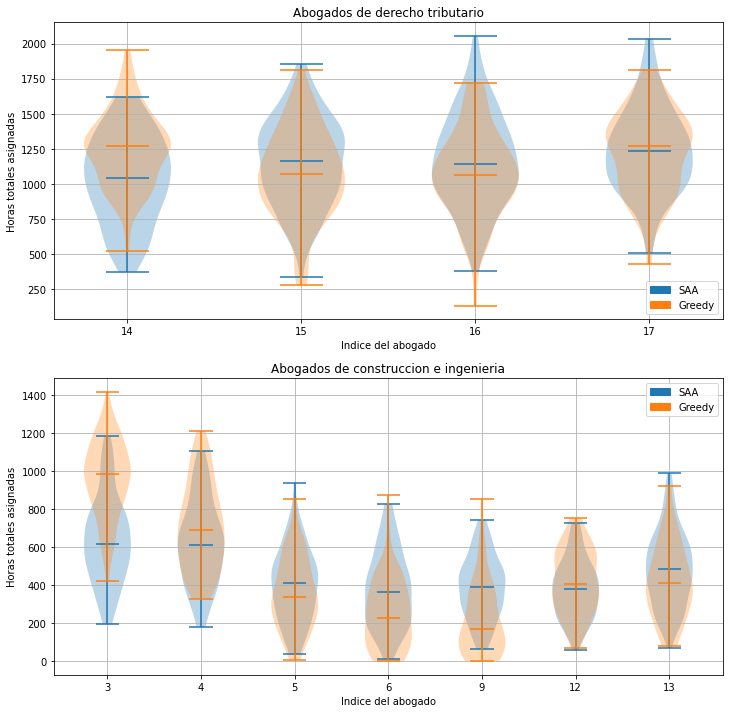

In [252]:
def add_label(violin, labels, label):
    if label=="Greedy":
        labels.append((mpatches.Patch(color="tab:orange"), label))
    else:
        labels.append((mpatches.Patch(color='tab:blue'), label))

fig, axs = plt.subplots(2, 1, figsize=(12, 12))

i=4
for ax1, key in zip(axs, [3, 63]):
    labels = []
    parts1 = ax1.violinplot(time[0, :, area_dict[key]].T, showmedians=True)
    parts2 = ax1.violinplot(time[1, :, area_dict[key]].T, showmedians=True)
    ax1.set_xticks([y for y in range(1, len(area_dict[key])+1)], labels=area_dict[key])
    ax1.set_title(f"Abogados de {specialty_decod[key]}")
    ax1.set_xlabel("Indice del abogado")
    ax1.set_ylabel("Horas totales asignadas")
    add_label(parts1, labels, "SAA")
    add_label(parts1, labels, "Greedy")
    ax1.legend(*zip(*labels), loc=i)
    i -= 4
    ax1.grid()
    
plt.show()

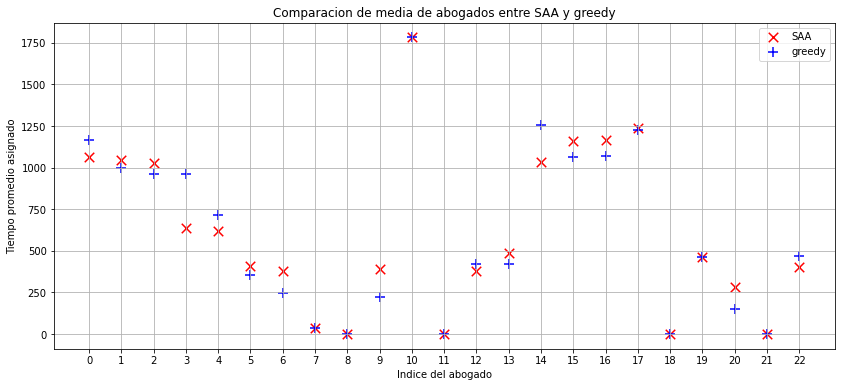

In [25]:
time.mean(axis=1).round(2)

fig, ax = plt.subplots(1, 1, figsize=(14, 6))
ax.scatter(np.arange(23), time.mean(axis=1)[0].round(2), marker="x", color="r", s=90)
ax.scatter(np.arange(23), time.mean(axis=1)[1].round(2), marker="+", color="b", s=90)
ax.set_xticks(np.arange(23))
ax.grid()
ax.legend(["SAA", "greedy"])
ax.set_ylabel("Tiempo promedio asignado")
ax.set_xlabel("Indice del abogado")
ax.set_title("Comparacion de media de abogados entre SAA y greedy")
plt.show()

### Conclusiones ###

En los primeros dos gráficos se puede observar como se distribuye la asignación de tiempo de los abogados para el modelo con SAA y el modelo greedy. Se aprecia que el modelo con SAA distribuye los tiempos de forma más uniforme, de manera que se cumple el objetivo de balancear la carga de trabajo para los abogados.

In [261]:
idx = ["Rating", "Servicios botados", "Abogados asignados"]
columns = ["Mejor que greedy", "Empate", "Peor que greedy"]
df = pd.DataFrame(columns=columns, index=idx)

# Correlacion entre cantidad de servicios de la repeticion y ranking #

In [26]:
print(
    f"Promedio SAA: {rating.mean(axis=1)[0]}",
    f"Promedio greedy: {rating.mean(axis=1)[1]}", sep="\n"
)

print(
    f"\nPromedio SAA por servicio: {(rating / total).mean(axis=1)[0]}",
    f"Promedio greedy por servicio: {(rating / total).mean(axis=1)[1]}", sep="\n"
)

Promedio SAA: 6289.820424134442
Promedio greedy: 6274.7602731859815

Promedio SAA por servicio: 20.88530242763301
Promedio greedy por servicio: 20.837707758765923


Vemos una ligera ventaja en rating por parte del modelo con SAA.

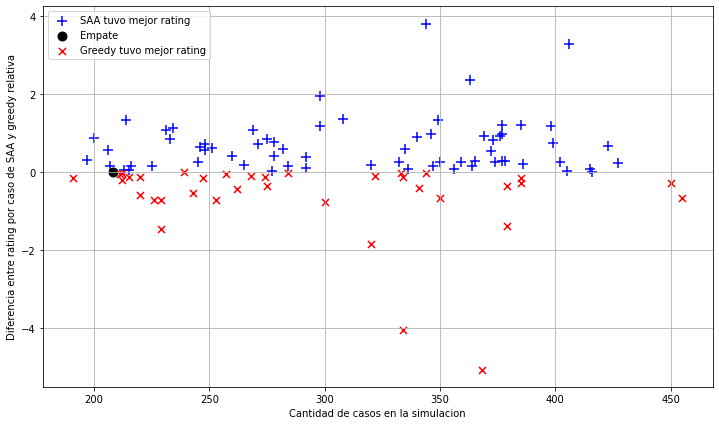

Ganamos 67 veces, perdimos 36 veces y hubo 1 empates


In [262]:
fig, ax1 = plt.subplots(1, 1, figsize=(12, 7))

scaled_rating = rating

diff = 100 * ((scaled_rating[0] - scaled_rating[1]) / scaled_rating[0])
ax1.scatter(total[diff > 0], (diff)[diff > 0],
            marker="+", c="b", s=90)
ax1.scatter(total[diff == 0], (diff)[diff == 0],
            marker="o", c="k", s=80)
ax1.scatter(total[diff < 0], (diff)[diff < 0],
            marker="x", c="r", s=50)

ax1.legend(["SAA tuvo mejor rating", "Empate", "Greedy tuvo mejor rating"])
ax1.set_xlabel("Cantidad de casos en la simulacion")
ax1.set_ylabel("Diferencia entre rating por caso de SAA y greedy relativa")
ax1.grid()

#ax2.boxplot(scaled_rating.T)
#ax2.set_ylabel("Rating promedio por servicio")
#ax2.set_xticks([1, 2], ["SAA", "Greedy"])
#ax2.grid()

plt.show()

lost = len(diff[diff < 0])
tie = len(diff[diff == 0])
won = len(diff[diff > 0])

df.loc["Rating", :] = won, tie, lost

print(f"Ganamos {won} veces, perdimos {lost} veces y hubo {tie} empates") 

In [29]:
diff.mean()

0.22124469232900074

In [30]:
np.corrcoef(total, diff)

array([[1.        , 0.05265667],
       [0.05265667, 1.        ]])

En el primer gráfico, en el eje x tenemos la cantidad de casos que llegaron en la simulación y en el eje y la diferencia relativa del rating total de las asignaciones entre SAA y greedy, es decir, si el dato tiene un valor de 1, significa que SAA tuvo un rating 1% mejor que greedy. Se hubiera esperado que mientras más casos llegaran en una simulación, mejor sería el desempeño del modelo con SAA en comparación al greedy. Sin embargo, la correlación entre cantidad de servicios y la diferencia de rating por caso no es significativa. 

# Servicios botados #

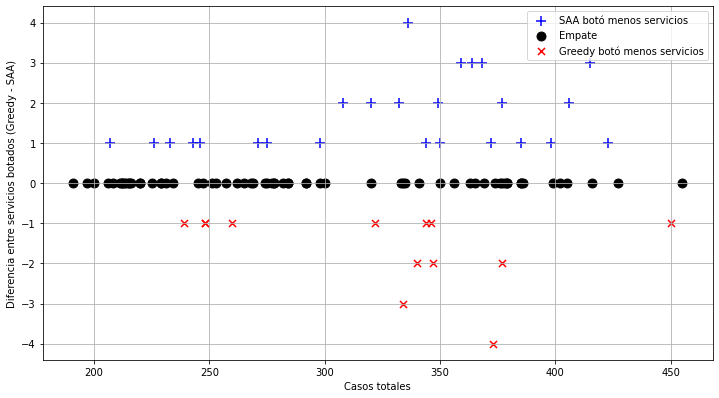

[61.47115385 61.67307692]
0.20192307692307693
Ganamos 25 veces, perdimos 13 veces y hubo 66 empates


In [263]:
fig, ax1 = plt.subplots(1, 1, figsize=(12, 6.5))

diff = droped[1] - droped[0]

ax1.scatter(total[diff > 0], (diff)[diff > 0],
            marker="+", c="b", s=90)
ax1.scatter(total[diff == 0], (diff)[diff == 0],
            marker="o", c="k", s=80)
ax1.scatter(total[diff < 0], (diff)[diff < 0],
            marker="x", c="r", s=50)

ax1.legend(["SAA botó menos servicios", "Empate", "Greedy botó menos servicios"])
ax1.set_xlabel("Casos totales")
ax1.set_ylabel("Diferencia entre servicios botados (Greedy - SAA)")
ax1.grid()

#ax2.boxplot(100 * (droped / total).T)
#ax2.set_xticks([1, 2], ["SAA", "Greedy"])
#ax2.grid()
#ax2.set_ylabel("% casos botados")

plt.show()

lost = len(diff[diff < 0])
tie = len(diff[diff == 0])
won = len(diff[diff > 0])

print((droped).mean(axis=1))
print(diff.mean())

df.iloc[1, :] = won, tie, lost

print(f"Ganamos {won} veces, perdimos {lost} veces y hubo {tie} empates") 

En este caso analizamos diferencia relativa de servicios botados. Vemos nuevamente que SAA tiene una ligera ventaja sobre greedy. La mayoría de las simulaciones se botan la misma cantidad de servicios, pero en la mayoría de las veces donde hay diferencias, SAA toma ventaja. Nuevamente este era uno de los resultados anticipados, sin embargo, se esperaba una diferencia más notoria.


# Asignaciones #

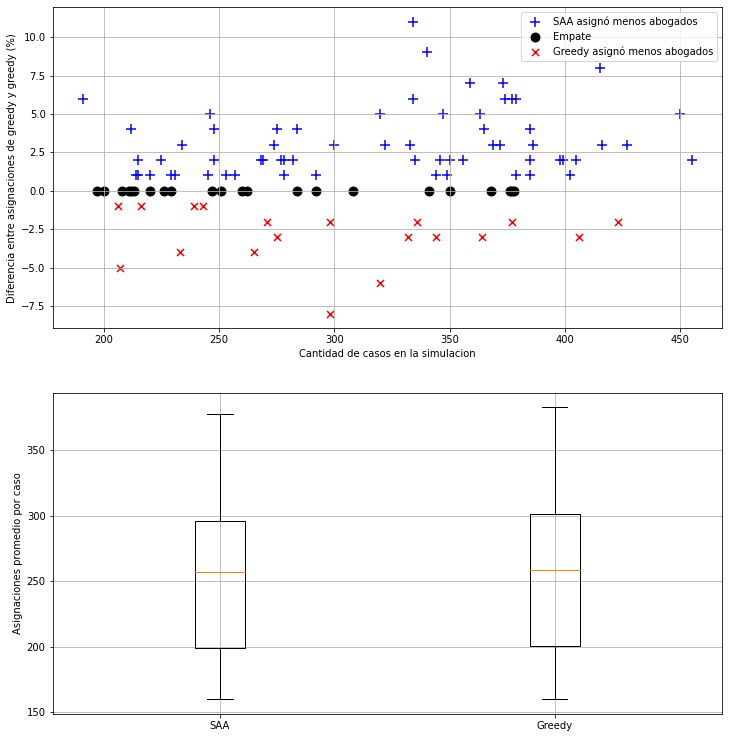

[251.04807692 252.43269231]
1.3846153846153846
Ganamos 63 veces, perdimos 19 veces y hubo 22 empates


In [264]:
scaled_assignments = assignments #/ total

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 13))

diff = ((scaled_assignments[1] - scaled_assignments[0]))
ax1.scatter(total[diff > 0], (diff)[diff > 0],
            marker="+", c="b", s=90)
ax1.scatter(total[diff == 0], (diff)[diff == 0],
            marker="o", c="k", s=80)
ax1.scatter(total[diff < 0], (diff)[diff < 0],
            marker="x", c="r", s=50)
ax1.set_xlabel("Cantidad de casos en la simulacion")
ax1.set_ylabel("Diferencia entre asignaciones de greedy y greedy (%)")
ax1.grid()
ax1.legend(["SAA asignó menos abogados", "Empate", "Greedy asignó menos abogados"])

ax2.boxplot(scaled_assignments.T)
ax2.set_ylabel("Asignaciones promedio por caso")
ax2.set_xticks([1, 2], ["SAA", "Greedy"])
ax2.grid()

plt.show()

lost = len(diff[diff < 0])
tie = len(diff[diff == 0])
won = len(diff[diff > 0])

print((scaled_assignments).mean(axis=1))
print(diff.mean())

df.iloc[2, :] = won, tie, lost
print(f"Ganamos {won} veces, perdimos {lost} veces y hubo {tie} empates") 

Por último, analizamos la cantidad de servicios asignados. De nuevo vemos que SAA tiene un mejor desempeño: asigna menos abogados por caso en promedio. Además, como ya se ha observado, asignando menos abogados obtiene un mejor rendimiento en promedio, tanto en rating como en cantidad de servicios botados, lo cual es probablemente el mejor resultado de todo el experimento. Esto porque tener un rating alto y tener pocas asignaciones son objetivos que compiten, es decir, para mejorar uno, es fácil empeorar en el otro. Por lo que encontrar una solución que encuentra un equilibrio donde ambas métricas mejoren es muy positivo.

# Selection #

In [75]:
br1, wr1, bd1, wd1, rs1, br2, wr2, bd2, wd2, rs2 = selection

In [228]:
k = 5
l = 1
best_rating_dict = selection[k][l]
la = np.zeros((2, 52))
ra = np.zeros((2, 52))
ns = np.zeros(52)
nb = np.zeros((2, 52))
tta = np.zeros((2, 23, 52))
tla = np.zeros((2, 53, 23))
tda = np.zeros((2, 52, A))
data2 = [la, ns, nb, ra, tta, tla, tda]

for i, key in enumerate(best_rating_dict['saa']):
    if key != "ns":
        if key == "tda":
            for week, dicc in best_rating_dict['saa']['tda'].items():
                for area, time in dicc.items():
                    tda[0, week, areas_idx[area]] += time
                    
            for week, dicc in best_rating_dict['greedy']['tda'].items():
                for area, time in dicc.items():
                    tda[1, week, areas_idx[area]] += time
                    
        else:
            data2[i][0] = best_rating_dict['saa'][key]
            data2[i][1] = best_rating_dict['greedy'][key]
    else:
        data2[2] = best_rating_dict['saa']['ns']
        
weeks = np.arange(52)

# Rating #

[8943.708 9003.44 ]


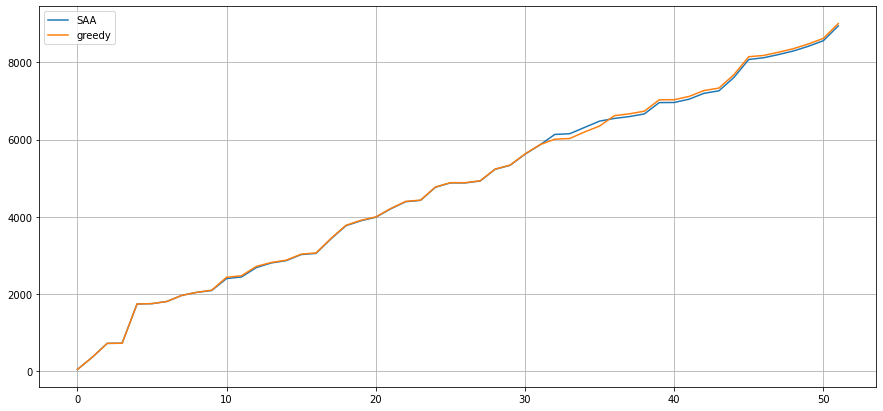

In [229]:
print(ra.sum(axis=1))

fig, ax = plt.subplots(1, 1, figsize=(15, 7))

ax.plot(weeks, np.cumsum(ra[0]))
ax.plot(weeks, np.cumsum(ra[1]))
ax.legend(["SAA", "greedy"])
ax.grid()

plt.show()

In [127]:
data2

[array([[ 1.,  2.,  7.,  8.,  3.,  4.,  9.,  5.,  6.,  2.,  4.,  1.,  5.,
          0.,  2.,  7.,  4.,  5.,  3.,  4.,  2.,  7.,  3.,  8.,  4.,  4.,
          0.,  8.,  0.,  0., 12.,  0.,  6.,  3., 12.,  3.,  1.,  0.,  6.,
          4.,  9.,  7.,  0.,  1.,  0.,  3.,  5.,  1.,  3., 14.,  6., 11.],
        [ 1.,  2.,  7.,  8.,  3.,  4.,  9.,  5.,  6.,  2.,  4.,  1.,  5.,
          0.,  2.,  7.,  4.,  5.,  3.,  4.,  2.,  7.,  3.,  8.,  4.,  4.,
          0.,  8.,  0.,  0., 10.,  0.,  6.,  3., 12.,  3.,  1.,  0.,  6.,
          4.,  9.,  7.,  0.,  1.,  0.,  3.,  5.,  1.,  3., 13.,  6., 10.]]),
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 

In [125]:
best_rating_dict['saa']['ra']

[5.0,
 27.5,
 99.384,
 213.8,
 44.8,
 136.48,
 398.0,
 210.60000000000002,
 51.0,
 14.5,
 87.7,
 6.0,
 151.4,
 0,
 4.2000000000000615,
 79.06400000000001,
 29.499999999999996,
 149.5,
 46.8,
 577.0,
 36.0,
 51.1,
 170.58,
 131.0,
 80.99999999999997,
 39.184,
 0,
 396.96000000000004,
 0,
 0.0,
 232.32002592,
 0.0,
 40.156,
 43.1,
 503.18,
 4.0,
 28.0,
 0,
 123.70000000000009,
 49.0,
 267.86,
 130.0,
 0,
 4.0,
 0,
 16.199999999999996,
 826.0,
 6.0,
 69.60000000000001,
 339.3480192,
 263.99999999999994,
 288.3]

In [266]:
print(df.to_latex())

\begin{tabular}{llll}
\toprule
{} & Mejor que greedy & Empate & Peor que greedy \\
\midrule
Rating             &               67 &      1 &              36 \\
Servicios botados  &               25 &     66 &              13 \\
Abogados asignados &               63 &     22 &              19 \\
\bottomrule
\end{tabular}

